thicknesses: [ 56.27840133 100.        ], roughnesses: [1.12804606 1.10221711], slds: [ 7.36500555 13.94726525]


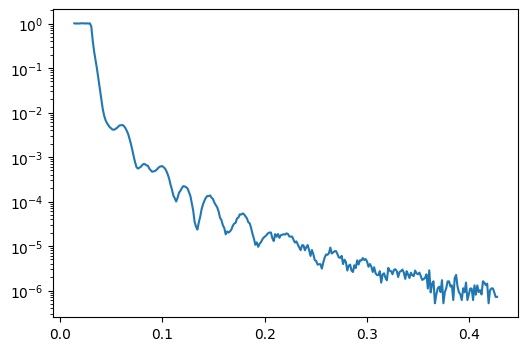

In [113]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from model_fused import PhysicsLayer

from reflecto.simulator.simulator import XRRSimulator, tth2q_wavelen

wavelen: float = 1.54  # (nm)
tth_min: float = 0.2   # degree
tth_max: float = 6.0
tth_n: int = 300
tths: np.ndarray = np.linspace(tth_min, tth_max, tth_n)
qs: np.ndarray = tth2q_wavelen(tths, wavelen)

xrr_simulator = XRRSimulator(qs, 2, 1)
thicknesses, roughnesses, slds, refl = next(xrr_simulator.make_params_refl())

print(f"thicknesses: {thicknesses}, roughnesses: {roughnesses}, slds: {slds}")

fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.plot(qs, refl)
ax.set_yscale("log")

plt.show()

In [114]:
refl_tensor = torch.tensor(np.log10(refl), dtype=torch.float32).unsqueeze(0)  # (1, Q)
qs_tensor = torch.tensor(qs, dtype=torch.float32)

print("실제 파라미터:")
print(f"두께: {thicknesses} Å")
print(f"거칠기: {roughnesses} Å")
print(f"SLD: {slds} Å^-2")

실제 파라미터:
두께: [ 56.27840133 100.        ] nm
거칠기: [1.12804606 1.10221711] Å
SLD: [ 7.36500555 13.94726525] Å^-2


In [115]:
# 주피터 셀 3: PhysicsLayer 실행
# PhysicsLayer 초기화
physics_layer = PhysicsLayer(qs_tensor, n_layers=2)

# 추정 실행
with torch.no_grad():
    est_thickness, confidence = physics_layer(refl_tensor)

# 결과 출력
print("\nPhysicsLayer 추정 결과:")
print(f"추정 두께: {est_thickness[0].numpy()} Å")
print(f"실제 두께: {thicknesses} Å")
print(f"MAE: {np.mean(np.abs(est_thickness[0].numpy()[:len(thicknesses)] - thicknesses)):.2f} Å")

[[np.float64(30.40999691283428), np.float64(54.737994443101705), np.float64(86.6684912015777)], [np.float64(30.40999691283428), np.float64(86.6684912015777), np.float64(115.55798826877027)], [np.float64(71.46349274516056), np.float64(86.6684912015777), np.float64(156.61148410109655)]]

PhysicsLayer 추정 결과:
추정 두께: [30.409996 54.737995] Å
실제 두께: [ 56.27840133 100.        ] Å
MAE: 35.57 Å


In [116]:
import scipy.signal.windows as fft_windows
import scipy as scp


def xrr_fft(x, y, d=None, window=2, n=None, step_num: int = 1000):
    """
    FFT 변환 (XRR 분석 전용)

    """
    # 등간격 보간
    f_cubic = scp.interpolate.interp1d(x, y, kind="cubic")
    x = np.linspace(x.min(), x.max(), step_num)
    y = f_cubic(x)

    if d is None:
        d = x[1] - x[0]

    N = len(y)
    if window == 0:
        w = np.ones(N)
    elif window == 1:
        w = fft_windows.hann(N)
    elif window == 2:
        w = fft_windows.hamming(N)
    else:
        w = fft_windows.flattop(N)

    if n is None:
        n = N

    yf = 2 / N * np.abs(scp.fftpack.fft(w * y / np.mean(w), n=n))
    xf = scp.fftpack.fftfreq(n, d=d)
    return xf[: n // 2], yf[: n // 2]

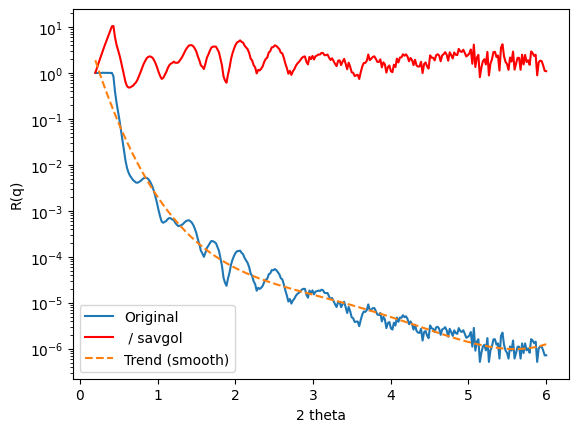

In [117]:
from itertools import combinations_with_replacement

from scipy import signal
from scipy.signal import argrelmax

# 주피터 셀 4: 신호 처리 과정 시각화 (FFT)
# FFT 계산 (PhysicsLayer 내부 과정)
R_log = np.log10(refl)
window_len = len(R_log)

R_smooth = signal.savgol_filter(R_log, window_length=window_len, polyorder=4, mode='interp')
savgol = 10 ** R_smooth
R_savgol = refl / savgol
R_savgol = R_savgol / (R_savgol[0] + 1e-12) * refl.max()

plt.figure()
plt.plot(tths, refl, label='Original')
plt.plot(tths, R_savgol, label=' / savgol', color='red')
plt.plot(tths, savgol, label='Trend (smooth)', linestyle='--')
plt.xlabel('2 theta')
plt.ylabel('R(q)')
plt.yscale('log')
plt.legend()
plt.show()

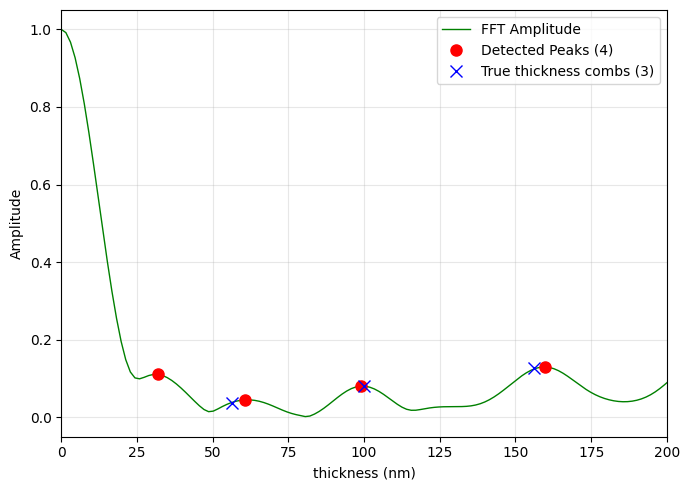

In [118]:
# FFT
xf, yf = xrr_fft(qs, R_savgol, window=2, n=10000)
x_fft = xf * 2 * np.pi
yf = yf / yf[0]
# 피크 검출
from scipy.signal import argrelmax

upper_idx = np.searchsorted(x_fft, 200.0)
detected_peaks = []
for order in [50, 30, 20, 10]:
    idx_max = argrelmax(yf[:upper_idx], order=order)[0]
    if len(idx_max) > 0:
        peaks = x_fft[idx_max]
        heights = yf[idx_max]
        strong_peaks = peaks[heights > 0.005]
        if len(strong_peaks) > 0:
            detected_peaks = strong_peaks
            break

# 플롯
fig, ax = plt.subplots(1, 1, figsize=(7, 5))

# FFT 및 피크
ax.plot(x_fft, yf, 'g-', linewidth=1, label='FFT Amplitude')
if len(peaks) > 0:
    thick_comb_idx = [np.argmin(np.abs(x_fft - p)) for p in peaks]
    ax.plot(peaks, yf[peak_indices], 'ro', markersize=8, label=f'Detected Peaks ({len(peaks)})')

thicknesses_comb = [sum(set(comb)) for comb in combinations_with_replacement(thicknesses, 2)]
thick_comb_idx = [np.argmin(np.abs(x_fft - p)) for p in thicknesses_comb]
ax.plot(thicknesses_comb, yf[thick_comb_idx], 'bx', markersize=8, label=f'True thickness combs ({len(thicknesses_comb)})')
ax.set_xlim(0, x_upper)
ax.set_xlabel('thickness (nm)')
ax.set_ylabel('Amplitude')
# axes[1].set_yscale('log')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [119]:
def valid_comb(peaks):
    result = []
    ln = len(peaks)
    for i in range(ln):
        for j in range(i, ln):
            remains = set(range(ln)) - {i, j}
            for k in remains:
                a = peaks[i]
                b = peaks[j]
                c = peaks[k]
                if abs(c - a - b) < 5:
                    result.append([a, b, c])
    return result
valid_combs = valid_comb(peaks)
print(valid_combs)

[[np.float64(31.93047937507314), np.float64(31.93047937507314), np.float64(60.81996071442504)], [np.float64(60.81996071442504), np.float64(98.83243616094067), np.float64(159.65239687536572)]]


AttributeError: 'list' object has no attribute 'item'

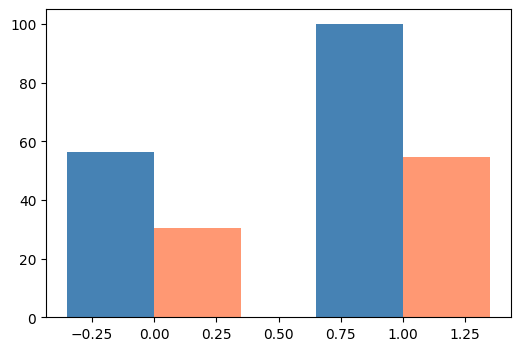

In [120]:
# 주피터 셀 5: 두께 비교 바 차트
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

layers = np.arange(len(thicknesses))
width = 0.35

# 실제 vs 추정
real_bar = ax.bar(layers - width/2, thicknesses, width, label='Real Thickness', color='steelblue')
est_values = est_thickness[0][:len(thicknesses)].cpu().numpy()
est_bar = ax.bar(layers + width/2, est_values, width, label='Physics Est.', color='coral', alpha=0.8)

# 신뢰도 표시
ax.text(0.02, 0.98, f'Confidence: {confidence[0].item():.3f}\nMAE: {np.mean(np.abs(est_values - thicknesses)):.2f} Å',
        transform=ax.transAxes, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

ax.set_xlabel('Layer Index')
ax.set_ylabel('Thickness (Å)')
ax.set_title('Real vs PhysicsLayer Estimation')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

plt.show()

In [ ]:
from dataset_fused import FusedDatasetH5

config = {
    "exp_name": "exp04_physics_fused",
    "h5_path": r"D:\data\XRR_AI\xrr_data.h5",
    "checkpoint_dir": r"D:\data\XRR_AI",
    "epochs": 30,
    "batch_size": 32,
    "lr": 1e-3,
    "weight_decay": 1e-5,
    "val_ratio": 0.2,
    "save_every": 5,
    "physics_weight": 0.5,    # 물리 모델 가중치
    "norm_ranges": {
        "thickness": [0.0, 200.0],
        "roughness": [0.0, 10.0],
        "sld": [0.0, 140.0]
    }
}

dataset = FusedDatasetH5(config["h5_path"], norm_ranges=config["norm_ranges"])
print(f"Thickness: min={dataset.thickness_range[0]}, max={dataset.thickness_range[1]}")

FileNotFoundError: 'D:\data\XRR_AI\xrr_data.h5' not found.